In [ ]:
%load_ext autoreload
%autoreload 2

from src import *

m = lambda s: s * 60
h = lambda s: s * 3600

In [ ]:
# file = ['08-OUT-ALL', 1]
file = ['09-IN-ALL', 1]
# file = ['11-IN-ALL', 1]
uuid = '042_large_dataset_1000/0'
# uuid = '000_test_2/0'
model_name = 'rvce'

model, config = load_model_locally(uuid, model_name=model_name, device='cuda:0')
video = Video(file, config)

from_time, till_time = video.get_from_till_time(Part.WHOLE)

predictions, probabilities = validate_video(video, model, from_time=from_time, till_time=till_time, return_probs=True, tqdm=tqdm)
labels = get_labels(video, from_time, till_time)

In [ ]:
events_intervals = video.events_end_time - video.events_start_time
len(events_intervals), np.mean(events_intervals), np.median(events_intervals), np.max(events_intervals)

In [ ]:
print("all windows * window length:")
print(time_formatter(predictions['n_counts'].shape[0] * config.window_length))
print()
print("empty windows * window length:")
print(time_formatter(np.sum(labels["n_counts"] == 0) * config.window_length))
print()
print("Prior accuracy (class 0): ", np.sum(labels["n_counts"] == 0) / len(labels["n_counts"]))
print("Prior accuracy (class 1): ", np.sum(labels["n_counts"] == 1) / len(labels["n_counts"]))

In [ ]:
plot_statistics(labels['n_counts'], predictions['n_counts'])
set_plt_svg()

error 0.053 = 3/57    confidence: 0.99998
error 0.053 = 3/57    confidence: 0.99999

error 0.053 = 3/57    time saved: 07:14:00
error 0.053 = 3/57    time saved: 07:14:00


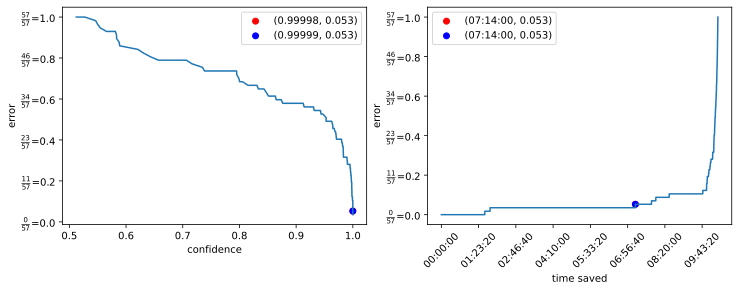

In [11]:
probs_0 = probabilities['n_counts'][:, 0].copy()
y_true = labels['n_counts'].copy()
y_pred = predictions['n_counts'].copy()

## set error threshold (y axis)
ERROR_THRESHOLD = 0.05
## set confidence (x axis)
CONFIDENCE = 0.99999
## set neighborhood size
EVENTS_NEIGHBOURHOOD = 1

kernel = np.full(2 * EVENTS_NEIGHBOURHOOD + 1, True)
mask = y_pred != 0
mask = np.convolve(mask, kernel, mode='same')
mask = ~mask
probs_0 = probs_0[mask]
y_true = y_true[mask]
y_pred = y_pred[mask]

## if we assume that the operator wants to reduce the time when visual engine
## does not detect anything, we can take only those windows with no cars 
## according to audio engine and measure the error
mask = y_pred == 0
probs_0 = probs_0[mask]
y_true = y_true[mask]
y_pred = y_pred[mask]

indices = probs_0.argsort()[::-1]

y_true_mask = y_true == 0
y_pred_mask = y_pred == 0

y_true_mask = y_true_mask[indices].astype(int)
y_pred_mask = y_pred_mask[indices].astype(int)
probs_0 = probs_0[indices]

n_events = (y_true != 0).sum()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ps = np.unique(probs_0)
# ps = np.linspace(0, 1, 1000)
ys = []
for p in ps:
    mask = probs_0 >= p
    # y = y_true_mask[mask].sum()
    y = np.sum(np.abs(y_true_mask[mask] - y_pred_mask[mask]))
    ys.append(y)

## normalize with number of windows with events
ys_normalized = np.array(ys) / n_events

i = np.argmin(np.abs(ys_normalized - ERROR_THRESHOLD))
axes[0].scatter(ps[i], ys_normalized[i], label=f"({ps[i]:.5f}, {ys_normalized[i]:.3f})", c='r')
axes[0].plot(ps, ys_normalized)
print(f'error {ys_normalized[i]:.3f} = {ys[i]}/{n_events}    confidence: {ps[i]:.5f}')
axes[0].set_ylabel("error")
axes[0].set_xlabel("confidence")

j = np.argmin(np.abs(ps - CONFIDENCE))
error_for_selected_confidence = ys_normalized[j]
axes[0].scatter(ps[j], error_for_selected_confidence, label=f"({ps[j]:.5f}, {error_for_selected_confidence:.3f})", c='b')
print(f'error {error_for_selected_confidence:.3f} = {ys[j]}/{n_events}    confidence: {ps[j]:.5f}')
print()



axes[1].set_xticklabels(axes[1].get_xticks(), rotation = 45)

xs = np.arange(len(y_true_mask)) * config.window_length
# cummulative error
ys = np.cumsum(np.abs(y_true_mask - y_pred_mask))
# y = cumerror / len(y_true_mask)
## normalize with number of windows with events
ys_normalized = ys / n_events
axes[1].plot(xs, ys_normalized)
axes[1].xaxis.set_major_formatter(tick.FuncFormatter(time_formatter))

def error_formatter(x, *args):
    return r'$\frac{' + f'{x * n_events:.0f}' + r'}{' + f'{n_events}' + r'}$' + f'={x:.1f}'

axes[0].yaxis.set_major_formatter(tick.FuncFormatter(error_formatter))
axes[1].yaxis.set_major_formatter(tick.FuncFormatter(error_formatter))

# ? find place where error is equal to ERROR_THRESHOLD
i = np.argmin(np.abs(ys_normalized - ERROR_THRESHOLD))
print(f'error {ys_normalized[i]:.3f} = {ys[i]}/{n_events}    time saved: {time_formatter(xs[i])}')
axes[1].set_ylabel("error")
axes[1].set_xlabel("time saved")
axes[1].scatter(xs[i], ys_normalized[i], label=f"({time_formatter(xs[i])}, {ys_normalized[i]:.3f})", c='r')

# ? find place where confidence is equal to CONFIDENCE
i = np.argmin(np.abs(ys_normalized - error_for_selected_confidence))
axes[1].scatter(xs[i], ys_normalized[i], label=f"({time_formatter(xs[i])}, {ys_normalized[i]:.3f})", c='b')
print(f'error {ys_normalized[i]:.3f} = {ys[i]}/{n_events}    time saved: {time_formatter(xs[i])}')

for ax in axes:
    ax.legend()

set_plt_svg()

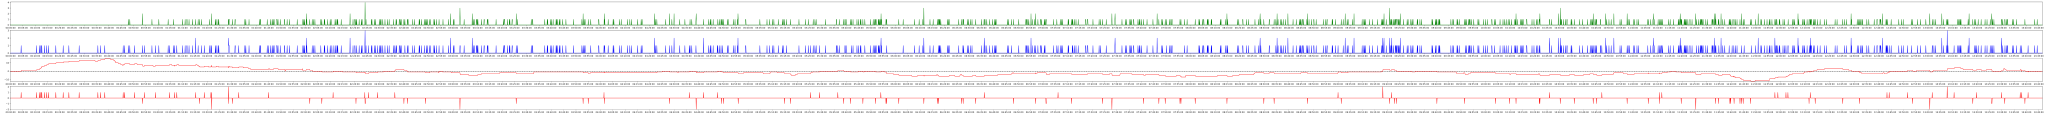

In [12]:
resolution = 300
n_last_elements = int(m(30) / config.window_length)
tick_frequency = m(5)

y_true = labels['n_counts']
y_pred = predictions['n_counts']


time_axis = np.arange(from_time, till_time + 1)

# fig, axes = plt.subplots(3, figsize=((till_time - from_time) / resolution, 7))
fig, axes = plt.subplots(4, figsize=((till_time - from_time) / resolution, 9))

def formatter(s, _):
        s = int(s)
        m = s // 60
        h = m // 60
        return f"{h:02d}:{m % 60:02d}:{s % 60:02d}"

for ax in axes:
    ax.margins(0, 0.02)
    ax.xaxis.set_major_formatter(tick.FuncFormatter(formatter))
    ax.set_xticks(np.arange(time_axis[0], time_axis[-1] + 1, tick_frequency))

x_axis_time = get_time(config, from_time, till_time)

# plot true
axes[0].plot(x_axis_time, np.append(y_true, 0), c='g')

# plot predicted
axes[1].plot(x_axis_time, np.append(y_pred, 0), c='b')

# plot difference
axes[2].axline([0, 0], slope=0, ls='--', c='black')
diff = y_pred - y_true

windowed_counting_error = []
for till_index in range(len(diff)):
    from_index = max(0, till_index - n_last_elements)
    windowed_counting_error.append(
        y_pred[from_index : till_index].sum() - 
        y_true[from_index : till_index].sum()
    )

axes[2].plot(x_axis_time, np.append(windowed_counting_error, 0), c='r')

axes[3].plot(x_axis_time, np.append(diff, 0), c='r')

set_plt_svg()